# T2* map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
# Ensure `data` and `methods` can be imported
import sys
sys.path.insert(0, '..')

# Other imports
import os                         
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import warnings

# UKRIN-MAPS modules
import data.fetch                  # Test data fetcher
from methods.T2Star import T2Star  # T2* mapping module

# Enable inline plotting; hide T2Star_Nottingham() RuntimeWarnings
%matplotlib inline
warnings.filterwarnings('ignore')

Tell python where to store the T2* map NIfTI file we will generate. We will store it in a directory called `t2star_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2star map
OUTPUT_DIR = os.path.join(os.getcwd(), "t2star_calculation_output")
OUTPUT_PATH = os.path.join(OUTPUT_DIR, 'T2StarMap.nii.gz')

Retrieve T2* test data using our data fetcher.
This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `TEs`: an array containing the echo times, in seconds.

In [7]:
# Fetch test data
image, affine, TEs = data.fetch.r2star_siemens()

[ 0  4  5  6  7  8  9 10 11  1  2  3]
(128, 128, 5, 12)


Compute the T2* map using the `T2Star` class implemented in `methods`:

In [8]:
# Compute T2star map
TEs = TEs*1000  # convert TEs to ms
t2star = T2Star(image, TEs).T2Star_Nottingham()[0]

Display a central slice of the T2* map. Note the units are _ms_.

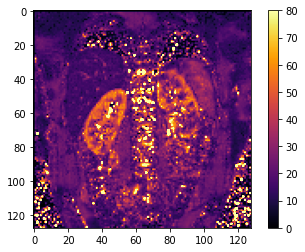

In [9]:
# Display a central slice of the T2star map
t2star_central_slice = np.rot90(t2star[:,:,2], 1)
ax = plt.subplots()[1]
im = ax.imshow(t2star_central_slice, cmap='inferno', vmin=0, vmax=80)
plt.colorbar(im)
plt.show()

Save the resulting T2* map as a NIfTI file:

In [6]:
# Save result as a new NifTI file
t2star_nifti_object = nib.Nifti1Image(t2star, affine=affine)
nib.save(t2star_nifti_object, OUTPUT_PATH)